In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import json
import pprint
from IPython.core.display import display
%matplotlib inline
import tweepy
import networkx as nx
import random
from pyvis.network import Network
from functions_file import *
data_folder = "data"
print("imported completed!")

imported completed!


In [2]:
consumer_key = "GvDHFIS3fpCfZR2hwEGhE5oCZ"
consumer_secret = "LCwgUZgFOjJppd4jg6Cf4mgohUTc6Ro7Yaals87LdNLmS3d9zB"
access_token = "810960428385890304-aVlOFR9EExKdDPZCsh5EDN5Nm9SUmb9"
access_secret = "XJkr9dKABPkSvRIgpyQeNapg2o6ldP4VoNbTids9QXGWT"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAA8UJQEAAAAAOD26yUUUPHF9zeAe56TtzGYUK8Q%3DRh6u9TAI7T7b5TJABTBOP5WwWSL0Cbvv5a6JJwg8MursyOOt9L"

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
if api.verify_credentials :
  print ('Authentication completed successfully!')

Authentication completed successfully!


In [56]:
def usersID (users,api):
    usersID = []
    for user in users:
        json_data = api.get_user(user)._json
        usersID.append(json_data["id"])
    return usersID

users = ["lucabazzetto","Tomve99"]
usersId = usersID(users,api)

In [57]:
def download_followers(idUser, quantity,api):
  followers_of_user = []
  for follower in tweepy.Cursor(
        api.followers,
        id = idUser,
        skip_status=True,
        include_user_entities = False
    ).items(quantity):
        #json_data = follower._json
        followers_of_user.append(follower._json["id"])
  return followers_of_user

quantity = 4
followers = {}
for idUser in usersId:
    followers[idUser] = download_followers(idUser, quantity,api)
serialize_json(data_folder,"followersLucaThomas.json", followers)

Data serialized to path: data/followersLucaThomas.json


In [58]:
def download_following(idUser, quantity,api):
  friends_of_user = []
  for friend in tweepy.Cursor(
        api.friends,
        id = idUser,
        skip_status=True,
        include_user_entities = False
    ).items(quantity):
        json_data = friend._json
        friends_of_user.append(friend._json["id"])
  return friends_of_user

quantity = 4
friends = {}
for idUser in usersId:
    friends[idUser] = download_following(idUser, quantity,api)
serialize_json(data_folder,"friendsLucaThomas.json", friends)

Data serialized to path: data/friendsLucaThomas.json


In [61]:
def random_json_with_control(json_array, quantity, all):
    a = quantity
    array = []
    while(a!=0):
        item = random.choice(json_array)
        if item not in array and item not in all:
            array.append(item)
            a = a-1
    return array

followersALL = read_json(f"{data_folder}/followersLucaThomas.json")
fiveFollowers = []
# Estraggo per ogni utente 5 followers
quantity = 1
for user in followersALL:
    fiveFollowers.extend(random_json_with_control(followersALL[user], quantity, fiveFollowers))

quantity = 2
followersOfFollowers = {}
for idUser in fiveFollowers:
    followersOfFollowers[idUser] = download_followers(idUser, quantity,api)

serialize_json(data_folder,"followersOfFollowers.json", followersOfFollowers)

Data read fron path: data/followersLucaThomas.json
Data serialized to path: data/followersOfFollowers.json


In [62]:
friendsALL = read_json(f"{data_folder}/friendsLucaThomas.json")
fiveFriends = []
# Estraggo per ogni utente 5 followers
quantity = 1
for user in friendsALL:
    fiveFriends.extend(random_json_with_control(friendsALL[user], quantity, fiveFriends))

quantity = 2
friendsOfFriends = {}
for idUser in fiveFriends:
    friendsOfFriends[idUser] = download_following(idUser,quantity,api)
serialize_json(data_folder,"friendsOfFriends.json", friendsOfFriends)

Data read fron path: data/friendsLucaThomas.json
Data serialized to path: data/friendsOfFriends.json


In [70]:
allFriends = {}
allFriends.update(read_json(f"{data_folder}/friendsOfFriends.json"))
allFriends.update(read_json(f"{data_folder}/followersOfFollowers.json"))
allFriends.update(read_json(f"{data_folder}/followersLucaThomas.json"))
allFriends.update(read_json(f"{data_folder}/friendsLucaThomas.json"))

vector = []
for (k,v) in allFriends.items():
    for item in v:
        if item not in vector:
            vector.append(item)
serialize_json(data_folder,"noDuplicati.json", vector)

Data read fron path: data/friendsOfFriends.json
Data read fron path: data/followersOfFollowers.json
Data read fron path: data/followersLucaThomas.json
Data read fron path: data/friendsLucaThomas.json
Data serialized to path: data/noDuplicati.json


In [75]:
def downlodUserDetails(userId,api):
    json_data = api.get_user(userId)._json
    foundInfo = {}
    foundInfo ['id'] = json_data['id']
    foundInfo ['name'] = json_data['name']
    foundInfo ['screen_name'] = json_data['screen_name']
    foundInfo ['location'] = json_data['location']
    foundInfo ['followers_count'] = json_data['followers_count']
    foundInfo ['friends_count'] = json_data['friends_count']
    return foundInfo

vector = read_json(f"{data_folder}/noDuplicati.json")
index = 0
usersDetails = {}
for userId in vector:
    usersDetails[index] = downlodUserDetails(userId,api)
    index = index + 1

df = pd.DataFrame.from_dict(usersDetails,orient='index')
display(df)
df.to_csv(data_folder,"usersDetails.csv", index=False, encoding='utf-8')

Data read fron path: data/noDuplicati.json


,id,name,screen_name,location,followers_count,friends_count
0,1252717049287237632,Ciccio Feltri,ciccio_feltri,,7,15
1,426038638,Thomas Verardo,Tomve99,,18,57
2,523623748,Agustin Campagnolo,crispy_mcbacon,"Azzano decimo, Pordenone",24,43
3,307423967,giuseppe cruciani,giucruciani,,442469,1479
4,810960428385890304,Luca Bazzetto,lucabazzetto,,4,30
5,44196397,Elon Musk,elonmusk,,40185549,101


In [40]:
#salvo in un dataframe le relazioni
def friendship(sourceid,targetid, api):
    friendship = api.show_friendship(source_id=sourceid, target_id=targetid)
    if friendship[0].following & friendship[0].followed_by:
        return "both"
    else:
        if friendship[0].following:
            return "sourceToTarget"
        if friendship[0].following:
            return "TargetToSource"
    return None

list = read_json(f"{data_folder}/noDuplicati.json")

index = 0
sourceTarget ={}
def searchInDict(source,target,dictionary):
    for (k,v) in dictionary.items():
        if(source == v['target'] and target == v['source']):
            return True
    return False

for source in list:
    for target in list:
        if not searchInDict(source,target,sourceTarget):
            relation = friendship(source,target,api)
            if relation:
                foundFriendship = {
                    "id": index,
                    "source": source,
                    "target": target,
                    "friendship": relation
                }
                sourceTarget[index] = foundFriendship
                index = index + 1

df = pd.DataFrame.from_dict(sourceTarget,orient='index')
display(df)
df.to_csv(data_folder,"sourceTarget.csv", encoding='utf-8')

Data read fron path: data/noDuplicati.json
Data serialized to path: data/provaJJ.json


Rate limit reached. Sleeping for: 50


,id,source,target,friendship
0,0,1252717049287237632,426038638,both
1,1,1252717049287237632,523623748,both
2,2,1252717049287237632,307423967,sourceToTarget
3,3,1252717049287237632,810960428385890304,both
4,4,426038638,523623748,both
5,5,426038638,810960428385890304,both
6,6,426038638,44196397,sourceToTarget
7,7,523623748,810960428385890304,both
8,8,810960428385890304,307423967,sourceToTarget
9,9,810960428385890304,44196397,sourceToTarget


In [47]:
dfUsersDetails = pd.read_csv("usersDetails.csv")
dfUsersFriendship = pd.read_csv("sourceTarget.csv")

graph = nx.DiGraph()

#aggiunta membri gruppo come attributi
graph.graph["members"] = ["Luca","Thomas","Agustin","Edoardo"]

for index,row in dfUsersDetails.iterrows():
    graph.add_node(row['id'], name = row['name'],screen_name=row['screen_name'],location = row['location'],followers_count = row['followers_count'],friends_count = row['friends_count'])

#print(graph.nodes.data())

for index, row in dfUsersFriendship.iterrows():
    if row["friendship"] == "sourceToTarget":
        graph.add_edge(row["source"], row["target"])
    elif row["friendship"] == "TargetToSource" :
        graph.add_edge(row["target"], row["source"])
    else :
        graph.add_edge(row["source"], row["target"])
        graph.add_edge(row["target"], row["source"])

nx.write_gpickle(graph,"data/orientedGraph.pkl")

In [105]:
dfUsersDetails = pd.read_csv("usersDetails.csv")
dfUsersFriendship = pd.read_csv("sourceTarget.csv")

graph = nx.Graph()
#aggiunta membri gruppo come attributi
graph.graph["members"] = ["Luca","Thomas","Agustin","Edoardo"]

for index,row in dfUsersDetails.iterrows():
    graph.add_node(row['id'], label = row['screen_name'],location = row['location'],followers_count = row['followers_count'],friends_count = row['friends_count'])

for index, row in dfUsersFriendship.iterrows():
    graph.add_edge(row["source"], row["target"],id = row['id'])

nx.write_gpickle(graph,"data/unOrientedGraph.pkl")

In [106]:
graph = nx.read_gpickle("data/unOrientedGraph.pkl")

nt = Network(
    height="100%",
    width="100%",
    bgcolor="222222",
    font_color="white",
    heading="progetto"
)
nt.barnes_hut()
nt.from_nx(graph)
neighbor_map = nt.get_adj_list()
for node in nt.nodes:
    node["value"] = len(neighbor_map[node['id']])
nt.show("grafico.html")

{'members': ['Luca', 'Thomas', 'Agustin', 'Edoardo']}


In [48]:
#punto 7/8/9
from networkx.algorithms.distance_measures import center

noOriented = nx.read_gpickle("data/unOrientedGraph.pkl")
oriented = nx.read_gpickle("data/orientedGraph.pkl")
if(nx.is_connected(noOriented)):
    print("Grafo connesso"),
    print("Centro: ", end=" ")
    print(nx.center(noOriented))
    print("Diametro: ", end=" ")
    print(nx.diameter(noOriented))
    print("Raggio: ", end=" ")
    print(nx.radius(noOriented))
    
    
else:
    print("Grafo non connesso")
    
if(nx.is_bipartite(noOriented)):
    print("Grafo bipartito")
else:
    print("Grafo non bipartito")
    

    
 #la centralità del mezzo è una misura della centralità in un grafico basato sui percorsi più brevi
bet = nx.betweenness_centrality(noOriented)
close = nx.closeness_centrality(noOriented)
degree = nx.degree_centrality(noOriented)
ind = nx.in_degree_centrality(oriented)
outd = nx.out_degree_centrality(oriented)
pr = nx.pagerank(oriented)
hits = nx.hits(noOriented)

print("Centralità del mezzo: ", end=" ")
print(bet)
print(" ")
print("Centralità della vicinanza: ", end=" ")
print(close)
print(" ")
print("Centralità di grado: ", end=" ")
print(degree)
print(" ")

print("In-degree centrality: ", end=" ")
print(ind)
print(" ")
print("Out-degree centrality: ", end=" ")
print(outd)
print(" ")
#Da vedere se bisogna modificare alpha (non so cosa sia) e altri parametri
print("Page Rank: ", end=" ")
print(pr)
print(" ")
#Vengono ripetuti 2 volte i dati
print("HITS: ", end=" ")
print()

Grafo connesso
Centro:  [810960428385890304]
Diametro:  2
Raggio:  1
Grafo non bipartito
Centralità del mezzo:  {1252717049287237632: 0.1, 426038638: 0.1, 523623748: 0.0, 307423967: 0.0, 810960428385890304: 0.30000000000000004, 44196397: 0.0}
 
Centralità della vicinanza:  {1252717049287237632: 0.8333333333333334, 426038638: 0.8333333333333334, 523623748: 0.7142857142857143, 307423967: 0.625, 810960428385890304: 1.0, 44196397: 0.625}
 
Centralità di grado:  {1252717049287237632: 0.8, 426038638: 0.8, 523623748: 0.6000000000000001, 307423967: 0.4, 810960428385890304: 1.0, 44196397: 0.4}
 
In-degree centrality:  {1252717049287237632: 0.6000000000000001, 426038638: 0.6000000000000001, 523623748: 0.6000000000000001, 307423967: 0.4, 810960428385890304: 0.6000000000000001, 44196397: 0.4}
 
Out-degree centrality:  {1252717049287237632: 0.8, 426038638: 0.8, 523623748: 0.6000000000000001, 307423967: 0.0, 810960428385890304: 1.0, 44196397: 0.0}
 
Page Rank:  {1252717049287237632: 0.18362997802196

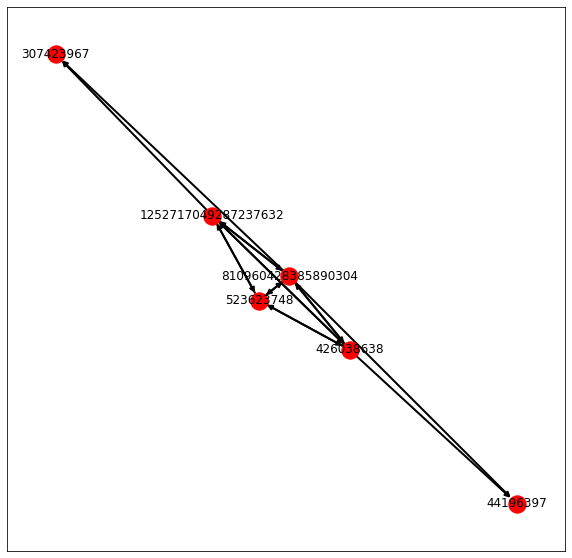

In [51]:
#Provo a disegnarlo (non scritto nella consegna)
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

nx.draw_networkx(
    oriented,
    pos = nx.spring_layout(oriented),
    node_color = "#FF0000",
    width = 2,
    edge_cmap = plt.cm.Blues,
    with_labels = True
)
plt.show()
plt.close()


In [50]:
#punto 10 (non richiesto il disegno)

oriented = nx.read_gpickle("data/orientedGraph.pkl")
tomve99 = nx.ego_graph(noOriented, "Tomve99", radius=1)

nx.draw_networkx(
    tomve99,
    pos = nx.spring_layout(tomve99),
    node_color = "#FF0000",
    edge_color = "#A9A9A9",
    width = 2,
    edge_cmap = plt.cm.Blues,
    with_labels = True
)
plt.savefig("data/tomve99.pdf")
plt.show()
plt.close()

NodeNotFound: Source Tomve99 is not in G

In [18]:
#punto 10b-c
from networkx.algorithms.approximation import clique

print("Cricca massima: ", end=" ")
print(clique.max_clique(tomve99))
print(" ")

print("Dimensione della cricca massima: ", end=" ")
print(clique.large_clique_size(tomve99))
print(" ")

Cricca massima:  {'ciccio_feltri', 'lucabazzetto', 'Tomve99', 'crispy_mcbacon'}
 
Dimensione della cricca massima:  4
 


In [ ]:
#Punto 11
#Per ora non funziona perché il grafo ha alcuni nodi senza archi
print("Copertura minima degli archi: ", end=" ")
print(nx.min_edge_cover(noOriented))
print(" ")


In [26]:
#Punto 12
#Per ora non funziona perché il grafo ha alcuni nodi senza archi
print("Coefficiente omega: ", end=" ")
print(nx.omega(tomve99))
print(" ")
print("Coefficiente sigma: ", end=" ")
print(nx.sigma(tomve99))
print(" ")
#Come si fa a stimare la small-world-ness? basta calcolare omega e sigma?

Coefficiente omega:  -2.220446049250313e-16
 
Coefficiente sigma:  0.9999999999999998
 


In [35]:
from scipy import stats
bet = nx.betweenness_centrality(noOriented)
close = nx.closeness_centrality(noOriented)
degree = nx.degree_centrality(noOriented)
ind = nx.in_degree_centrality(oriented)
outd = nx.out_degree_centrality(oriented)
pr, hits 

#Trasmormare tutti vettori in vettori di solo numeri?
#Calcolare l'indice facendo due for o uno solo?
#fare for e calcolare per ogni vettore l'indice pearson e kendall
pearson = np.array([bet, close, degree, ind, outd])
stats.stats.pearsonr(bet, close)

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [38]:



from scipy import stats
a = np.array([0, 0, 0, 1, 1, 1, 1])
b = np.arange(7)
stats.pearsonr(a, b)

[0 1 2 3 4 5 6]
